# <a id="0"></a> Table of Contents
6. [Importing Libraries](#6)     
7. [Instantiating Directories & Importing Datasets](#7) 
8. [Keras CNN](#8)<br>
    8.1. [Universal Settings - Image Pre-processing & Augmentation](#8.1)<br>
    8.2. [Baselince Model - Imbalanced Set](#8.2)<br>
    8.3. [Running Model With Balanced Set](#8.3)<br>
    8.4. [Further Model Optimization](#8.4)


<b>Note:</b> please refer to [satimclass_data_cleaning](https://github.com/Evangelos-Z/Ironhack_Final_Project-Sat_Img_Class/blob/main/satimclass_data_cleaning.ipynb) for an overview of the data processing that took place before.

# <a id="6"></a> <font color = "lightseagreen">6. Importing Libraries<font>

In [1]:
# Basic Libraries
import pandas as pd
import numpy as np
import sys

# Path & File Management
import os
import shutil
import re

# Visualization Libraries
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

# Image Manipulation/Processing
from PIL import Image

# CNNs, Classification, Dataset Access, Image Augmentation
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing import image

# Evaluation Metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Settings
import warnings
import time

# Notifications
import winsound

In [2]:
# Session parameters
warnings.filterwarnings("ignore")
np.set_printoptions(threshold=sys.maxsize)

# <a id=7></a><font color = "lightseagreen">7. Instantiating Directories & Importing Dataframes<font>

In [3]:
# Loading all dirs and dfs related to the dataset
# Paths for imbalanced dataset
data_path = os.path.join(os.getcwd(), "data - last version")
imbalanced_test_dir = os.path.join(data_path, "test")

# Paths for balanced dataset
data_balance = os.path.join(os.getcwd(), "data_balance")
balanced_test_dir = os.path.join(data_balance, "test")

# <a id = 8></a><font color="lightseagreen">8. Keras CNN<font>

In [4]:
# Function to generate keras CNN model structure. 
def make_model(input_shape): 
    inputs = keras.Input(shape=input_shape)

    x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(128, (1, 1), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(256, (2, 2), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dense(4, activation='softmax')(x)

    return keras.Model(inputs, x)

# courtesy of @isi_mube (Github)

## <a id = 8.1></a><font color="lightseagreen">8.1 Universal Settings - Image Pre-processing & Augmentation<font>

In [5]:
# Comparison in the accuracy scores and loss of models run with 64x64, 128x128 and 256x256 res showed that 256x256 had better overall scores
img_height = 256 
img_width = 256
image_size = (img_height, img_width)

In [6]:
# Image augmentation will increase the number of images the model will train on on the fly by applying random rescaling, changing brightness,
# adding distortion etc. as the model runs through its epochs
datagen = ImageDataGenerator(
    rescale=1.0/255,  # Important for normalization of input and avoiding larger images having greater weights
    brightness_range=[.6, 1.3],  # Value randomly selected from range between values of list, which were arbitrarily selected
    channel_shift_range=0.2,  # Channel shift is used to introduce the color augmentation in the dataset so as to make the model learn color based features irrespective of its saturation value.https://stackoverflow.com/questions/70515757/difference-between-channel-shift-range-and-brightness-range-in-imagedatagenerato 
    zoom_range=0.4,
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

In [7]:
# Picking minibatches of relatively medium proportions to start with for the comparison between imbalanced and balanced data
batch_size = 128

## <a id = 8.2><font color="lightseagreen">8.2 Baseline Model - Imbalanced Set<font></a>

### <font color="lightseagreen">- Setting Up and Running Model<font>

In [8]:
# The model requires that the train and validation data exist in directories dependent on their categories,
# so train and valid directories, along with their nested subdirectories will be will be used
train_dir_imb = os.path.join(data_path, "train")
val_dir_imb = os.path.join(data_path, "valid")

In [9]:
# Loading training data
train_ds_imb = datagen.flow_from_directory(
    train_dir_imb,
    seed=400,  # just has to stay the same, equivalent of random_state
    target_size=image_size,
    batch_size=batch_size,  # how many images per step
    class_mode="categorical"  # for multi-class
)

# Loading validation data
val_ds_imb = datagen.flow_from_directory(
    val_dir_imb,
    seed=400,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical"
)

Found 4474 images belonging to 4 classes.
Found 559 images belonging to 4 classes.


In [10]:
# Defining model
model = make_model(input_shape=image_size + (3,))

In [11]:
# Compiling model
model.compile(
    optimizer=keras.optimizers.Adamax(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [32]:
# Defining step sizes as exact divisors of the train and test set respectively. This way the model will run through
# the entire set each epoch
step_size_train = train_ds_imb.n//train_ds_imb.batch_size
step_size_val = val_ds_imb.n//val_ds_imb.batch_size

# Setting up directory to store versions of the model. The best one will be picked and reloaded
callbacks = [
    keras.callbacks.ModelCheckpoint("data - last version/epochs_imbalanced_data/save_at_{epoch}.keras")
]

### <font color="lightseagreen">- Training & Evaluation<font>

In [33]:
# Custom-made sound notification for when a cell is done executing
def cell_done():
    freq = 500
    dur = 50
    for i in range(0, 10):   
        winsound.Beep(freq, dur)   
        freq-= 20
        dur+= 50

In [34]:
# Making sure model training starts from scratch
keras.backend.clear_session()

In [35]:
# And finally training the model
hist = model.fit(
    train_ds_imb, 
    epochs=50,
    steps_per_epoch = step_size_train,
    validation_data=val_ds_imb,
    validation_steps = step_size_val,
    callbacks = callbacks
)

#cell_done()

Epoch 1/50
34/34 [==============================] - 177s 5s/step - loss: 0.6410 - accuracy: 0.6567 - val_loss: 0.5183 - val_accuracy: 0.7070
Epoch 2/50
34/34 [==============================] - 182s 5s/step - loss: 0.4444 - accuracy: 0.7800 - val_loss: 0.3987 - val_accuracy: 0.8438
Epoch 3/50
34/34 [==============================] - 181s 5s/step - loss: 0.3702 - accuracy: 0.8394 - val_loss: 0.3693 - val_accuracy: 0.8320
Epoch 4/50
34/34 [==============================] - 181s 5s/step - loss: 0.3653 - accuracy: 0.8488 - val_loss: 0.3795 - val_accuracy: 0.8262
Epoch 5/50
34/34 [==============================] - 181s 5s/step - loss: 0.3280 - accuracy: 0.8672 - val_loss: 0.3155 - val_accuracy: 0.8770
Epoch 6/50
34/34 [==============================] - 178s 5s/step - loss: 0.3279 - accuracy: 0.8608 - val_loss: 0.3600 - val_accuracy: 0.8516
Epoch 7/50
34/34 [==============================] - 178s 5s/step - loss: 0.3426 - accuracy: 0.8525 - val_loss: 0.3568 - val_accuracy: 0.8340
Epoch 8/50
34

In [12]:
# Saving scores for easy access
#imbalanced_hist_df = pd.DataFrame(hist.history)
#imbalanced_hist_df.to_csv("data - last version/base_imbalanced_scores.csv", index = 0)
imbalanced_hist_df = pd.read_csv("data - last version/base_imbalanced_scores.csv")

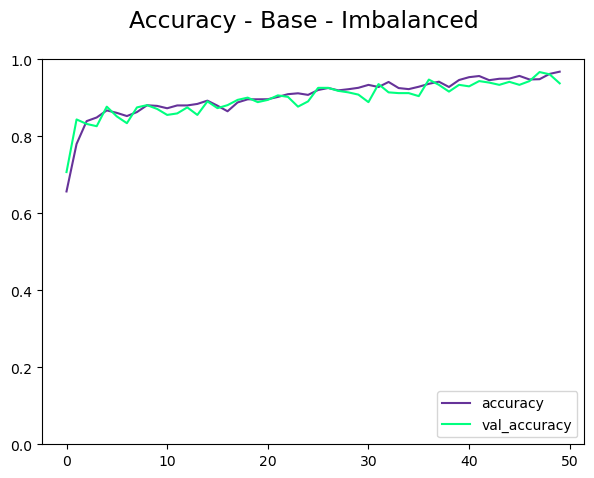

In [14]:
# Plotting accuracy from model history
fig = plt.figure(figsize = (7,5))
plt.plot(imbalanced_hist_df["accuracy"], color="rebeccapurple", label="accuracy")
plt.plot(imbalanced_hist_df["val_accuracy"], color="springgreen", label="val_accuracy")
plt.ylim(0,1)
fig.suptitle("Accuracy - Base - Imbalanced", fontsize=17)
plt.legend(loc="lower right")
plt.show()

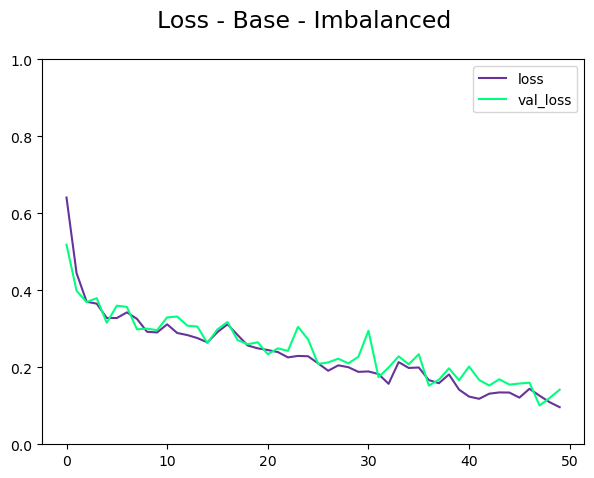

In [15]:
# Plotting loss from history
fig = plt.figure(figsize = (7,5))
plt.plot(imbalanced_hist_df["loss"], color="rebeccapurple", label="loss")
plt.plot(imbalanced_hist_df["val_loss"], color="springgreen", label="val_loss")
plt.ylim(0,1)
fig.suptitle("Loss - Base - Imbalanced", fontsize=17)
plt.legend(loc="upper right")
plt.show()

The learning curve reaches impressive values pretty fast, but is not very smooth, which is to be expected, since data augmentation has been applied. Drops in accuracy are of course in tandem with increases in crossentropy loss, which plays the role of the loss function for the model. The fact that the model seems to not yet have reached its learning curve and crossentropy loss plateau indicates that it potentially needs to run for at least a few more epochs to realise its full potential.

In [17]:
# Creating customized colormap for the confusion matrix
colors = [[0/255, 250/255, 154/255], [102/255,51/255,153/255]] # first color is MediumSpringGreen, last is RebeccaPurple
cm_funkyish = LinearSegmentedColormap.from_list(
        "Custom", colors, N=256, gamma = 2)

<h3 style = "color:lightseagreen">- Testing Against Unseen Data (test set)</h3>

In [18]:
# To turn images in the specified directory to arrays, which will then be appended to a list of arrays *function written partially by ChatGPT
def load_test_data(test_directory, target_size):
    image_arrays = []
    
    # turning images to arrays
    for filename in os.listdir(test_directory):
        img_path = os.path.join(test_directory, filename)
        img = load_img(img_path, target_size=target_size)
        img_array = img_to_array(img)
        
        image_arrays.append(img_array)
    
    # storing all image data in numpy array
    test_data_array = np.array(image_arrays)

    return test_data_array

In [19]:
# Creating path
temp_test_dir = os.path.join(imbalanced_test_dir, "test_temp")

# Copying data
dest = shutil.copytree(imbalanced_test_dir + "/" + "test", temp_test_dir)

In [20]:
# Load the test data and labels
test_data = load_test_data(temp_test_dir, image_size)

# Normalize the data
test_data = test_data / 255.0

18/18 [==============================] - 4s 230ms/step


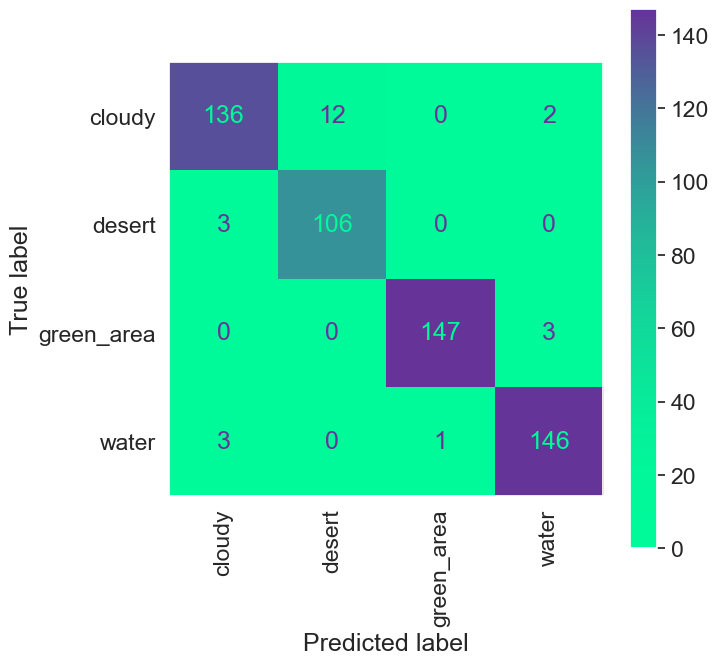

              precision    recall  f1-score     support
cloudy         0.957746  0.906667  0.931507  150.000000
desert         0.898305  0.972477  0.933921  109.000000
green_area     0.993243  0.980000  0.986577  150.000000
water          0.966887  0.973333  0.970100  150.000000
accuracy       0.957066  0.957066  0.957066    0.957066
macro avg      0.954046  0.958119  0.955526  559.000000
weighted avg   0.958134  0.957066  0.957111  559.000000


In [22]:
# Loading true labels from validation path
true_labels = val_ds_imb.classes

# Predicting test data using the model
pred_imb = model.predict(test_data)

# Converting predicted probabilities to class labels (the index of the highest probability)
pred_labels = np.argmax(pred_imb, axis=-1)

# Compute the confusion matrix
cm_imb = confusion_matrix(true_labels, pred_labels)

# Getting class names
class_names = list(val_ds_imb.class_indices.keys())

# Plotting confusion matrix
fig, ax = plt.subplots(figsize=(7, 7))  # Increase the size of the figure
cm_viz = ConfusionMatrixDisplay(confusion_matrix=cm_imb, display_labels=class_names)
cm_viz.plot(ax=ax, cmap=cm_funkyish, xticks_rotation='vertical')
ax.grid(False)
plt.show()

sns.set(font_scale=1.5)
report = classification_report(true_labels, pred_labels, target_names=class_names, output_dict=True)
df_report = pd.DataFrame(report).transpose()

print(df_report)

shutil.rmtree(temp_test_dir)

The accuracy score of 96% on imbalanced data after only 50 epochs is fairly satisfactory. Most erroneous predictions were made between the classes cloudy and desert. We see that 12 cloudy images were falsely categorised as desert and 3 desert images were categorised as cloudy. There also seems to be some confusion between water and cloudy, as well as water and green_area pictures, but these are minimal. Overall, although the desert class was under-represented, the model managed to predict its class fairly well, since only 3 of the 109 desert images were falsely classified. The model's highest success rate is observed in the classification of green areas.

<h3 style = "color:lightseagreen">- Demo With Test Data</h3>

Example No 1: 



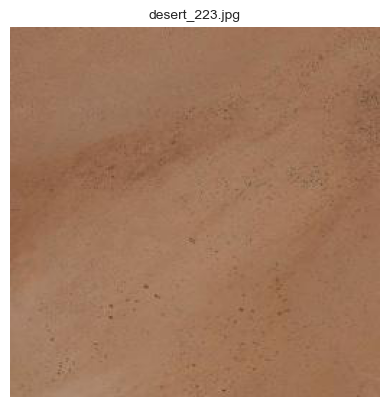

1/1 [==============================] - 0s 35ms/step
The model classifies this as: desert with 100.00% confidence 

Example No 2: 



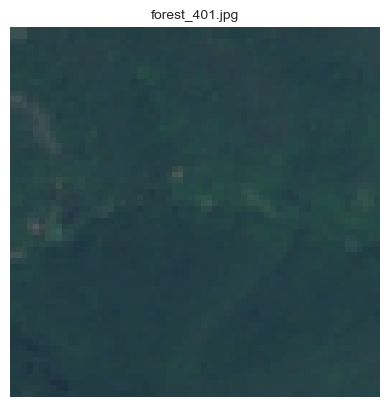

1/1 [==============================] - 0s 32ms/step
The model classifies this as: water with 100.00% confidence 

Example No 3: 



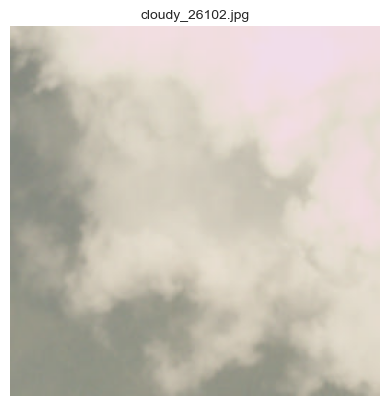

1/1 [==============================] - 0s 31ms/step
The model classifies this as: cloudy with 100.00% confidence 



In [28]:
# Adapted from @isi_mube (Github)
for i in range(1, 4):
    print(f"Example No {i}:", "\n")
    rand_img_dir = np.random.choice(os.listdir(imbalanced_test_dir + "/" + "test"))
    img_path = os.path.join(imbalanced_test_dir + "/" + "test", rand_img_dir)

    img = Image.open(img_path)
    plt.imshow(img)
    plt.axis('off') 
    plt.title(f"{rand_img_dir}", fontsize = 10)
    plt.show()

    # load and preprocess image
    img = image.load_img(img_path, target_size=(256,256))
    img_array = np.expand_dims(image.img_to_array(img), axis=0)

    # predict class
    predictions = model.predict(img_array)
    class_idx = np.argmax(predictions[0])  # class with highest probability
    class_prob = predictions[0][class_idx]

    # class label and confidence
    class_label = {v: k for k, v in train_ds_imb.class_indices.items()}[class_idx]
    print(f"The model classifies this as: {class_label} with {class_prob*100:.2f}% confidence", "\n")

As we can see, even with 96% accuracy, false classification is not unheard of.

## <a id = 8.3></a><font color="lightseagreen">8.3 Running Model With Balanced Set<font>

### <font color="lightseagreen">- Setting Up<font>

In [29]:
# Making sure model training starts from scratch
keras.backend.clear_session()

Repeating process

In [30]:
train_dir_bal = os.path.join(data_balance, "train")
val_dir_bal = os.path.join(data_balance, "valid")

In [31]:
train_bal_ds = datagen.flow_from_directory(
    train_dir_bal,
    seed=400,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical"
)

val_bal_ds = datagen.flow_from_directory(
    val_dir_bal,
    seed=400,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
)

Found 3496 images belonging to 4 classes.
Found 436 images belonging to 4 classes.


In [32]:
model = make_model(input_shape=image_size + (3,))

In [33]:
model.compile(
    optimizer=keras.optimizers.Adamax(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [15]:
step_size_btrain = train_bal_ds.n//train_bal_ds.batch_size
step_size_bval = val_bal_ds.n//val_bal_ds.batch_size

callbacks = [
    keras.callbacks.ModelCheckpoint("data_balance/epochs_bal_base/save_at_{epoch}.keras")
]

### <font color="lightseagreen">- Training & Evaluation<font>

In [66]:
hist = model.fit(
    train_bal_ds, 
    epochs=50,
    steps_per_epoch = step_size_btrain,
    validation_data=val_bal_ds,
    validation_steps = step_size_bval,
    callbacks = callbacks
)

cell_done()

Epoch 1/50
27/27 [==============================] - 134s 5s/step - loss: 0.6777 - accuracy: 0.6502 - val_loss: 0.4624 - val_accuracy: 0.7083
Epoch 2/50
27/27 [==============================] - 131s 5s/step - loss: 0.3971 - accuracy: 0.8254 - val_loss: 0.3371 - val_accuracy: 0.8594
Epoch 3/50
27/27 [==============================] - 131s 5s/step - loss: 0.3617 - accuracy: 0.8465 - val_loss: 0.4094 - val_accuracy: 0.8229
Epoch 4/50
27/27 [==============================] - 133s 5s/step - loss: 0.3413 - accuracy: 0.8550 - val_loss: 0.3366 - val_accuracy: 0.8646
Epoch 5/50
27/27 [==============================] - 130s 5s/step - loss: 0.3261 - accuracy: 0.8670 - val_loss: 0.3119 - val_accuracy: 0.8672
Epoch 6/50
27/27 [==============================] - 130s 5s/step - loss: 0.3235 - accuracy: 0.8726 - val_loss: 0.3022 - val_accuracy: 0.8854
Epoch 7/50
27/27 [==============================] - 130s 5s/step - loss: 0.2967 - accuracy: 0.8821 - val_loss: 0.2886 - val_accuracy: 0.8776
Epoch 8/50
27

In [36]:
# # to fix facecolor that turned gray for some reason https://stackoverflow.com/questions/4581504/how-to-set-opacity-of-background-colour-of-graph-with-matplotlib#:~:text=If%20you%20want%20to%20make,of%20all%20facecolors%20to%200%25.
# plt.rcParams.update({
#     "figure.facecolor":  (1.0, 0.0, 0.0, 0.0),  # red   with alpha = 30%
#     "axes.facecolor":    (0.0, 1.0, 0.0, 0.0),  # green with alpha = 50%
#     "savefig.facecolor": (0.0, 0.0, 1.0, 0.0),  # blue  with alpha = 20%
#     "legend.facecolor": "white"
# })

In [34]:
# balanced_hist_df = pd.DataFrame(hist.history)
# balanced_hist_df.to_csv("data_balance/base_balanced_scores.csv", index = 0)
balanced_hist_df = pd.read_csv("data_balance/base_balanced_scores.csv")

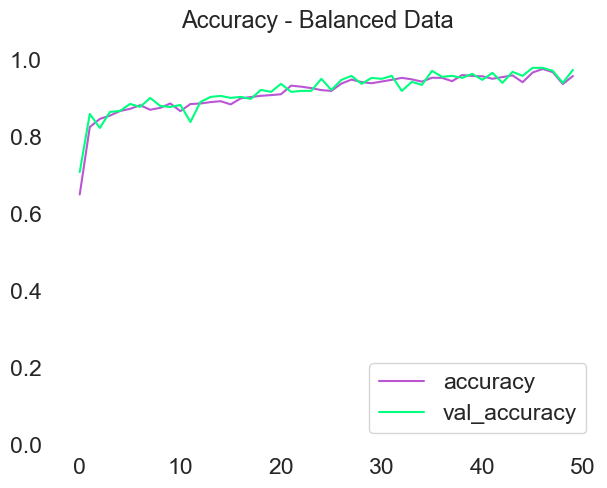

In [49]:
fig = plt.figure(figsize = (7,5))
plt.plot(balanced_hist_df["accuracy"], color="mediumorchid", label="accuracy")
plt.plot(balanced_hist_df["val_accuracy"], color="springgreen", label="val_accuracy")
fig.suptitle("Accuracy - Balanced Data", fontsize=17)
plt.ylim(0, 1)
plt.legend(loc="lower right")

plt.show()

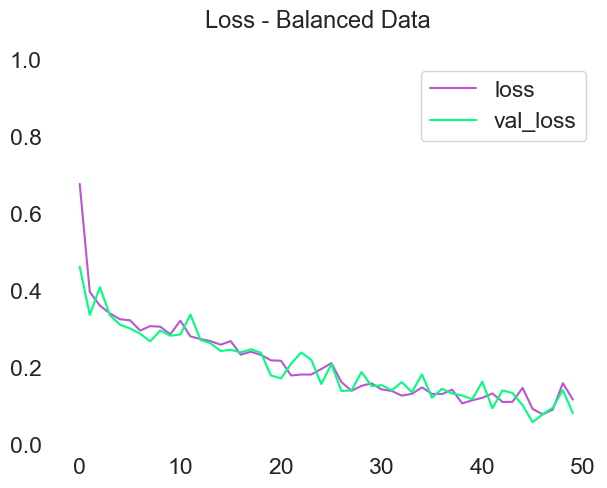

In [38]:
fig = plt.figure(figsize = (7,5))
plt.plot(balanced_hist_df["loss"], color="mediumorchid", label="loss")
plt.plot(balanced_hist_df["val_loss"], color="springgreen", label="val_loss")
fig.suptitle("Loss - Balanced Data", fontsize=17)
plt.ylim(0, 1)
plt.legend(loc="upper right")
plt.show()

There is an obvious, but not overwhelming difference in the learning and loss function curves of the model when trained with balanced data. They are generally smoother and there are lesser differences to be observed between them and their equivalents from the validation set. The model manages to approach its plateaus faster.

### <font color="lightseagreen">- Testing Against Unseen Data (test set)<font>

In [ ]:
# Best Epoch is 47 - Highest accuracy, least difference between loss and val_loss. Accuracy and val_accuracy practically identical
checkpoint_path_base_bal = os.path.join(data_balance, "epochs_bal_base", "save_at_47.keras")
model.load_weights(checkpoint_path_base_bal)

In [51]:
# Creating customized colormap for the confusion matrix
colors = [[0/255, 250/255, 154/255], [186/255, 85/255, 211/255]] # first color is MediumSpringGreen, last is MediumOrchid
cm_funky = LinearSegmentedColormap.from_list(
        "Custom", colors, N=256, gamma = 2)

In [54]:
bal_test_temp = os.path.join(balanced_test_dir, "test_temp")
dest = shutil.copytree(balanced_test_dir + "/" + "test", bal_test_temp)

In [55]:
test_data = load_test_data(bal_test_temp, image_size)
test_data = test_data / 255.0

14/14 [==============================] - 3s 231ms/step


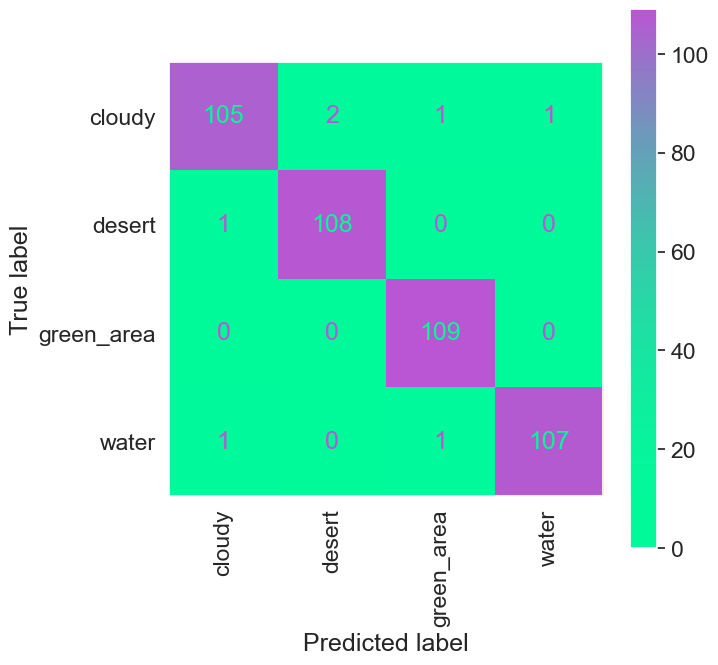

              precision    recall  f1-score     support
cloudy         0.981308  0.963303  0.972222  109.000000
desert         0.981818  0.990826  0.986301  109.000000
green_area     0.981982  1.000000  0.990909  109.000000
water          0.990741  0.981651  0.986175  109.000000
accuracy       0.983945  0.983945  0.983945    0.983945
macro avg      0.983962  0.983945  0.983902  436.000000
weighted avg   0.983962  0.983945  0.983902  436.000000


In [56]:
true_labels = val_bal_ds.classes
pred_bal = model.predict(test_data)

pred_labels = np.argmax(pred_bal, axis=-1)

cm_bal = confusion_matrix(true_labels, pred_labels)

class_names = list(val_bal_ds.class_indices.keys())

fig, ax = plt.subplots(figsize=(7, 7))  # Increase the size of the figure
cm_viz = ConfusionMatrixDisplay(confusion_matrix=cm_bal, display_labels=class_names)
cm_viz.plot(ax=ax, cmap=cm_funky, xticks_rotation='vertical')
ax.grid(False)
plt.show()

sns.set(font_scale=1.5)
report = classification_report(true_labels, pred_labels, target_names=class_names, output_dict=True)
df_report = pd.DataFrame(report).transpose()

print(df_report)

The model has performed decidedly better after training on balanced data, reaching an accuracy score of 98%. Once again, the most confusion seems to exist between cloudy and desert images, while in the case of the green area class all true positives were classified correctly and only 2 images were falsely categorised as green areas, which is depicted in the 100% recall and 99% f1-score of the class respectively.

<h3 style = "color:lightseagreen">- Demo</h3>

Example No 1: 



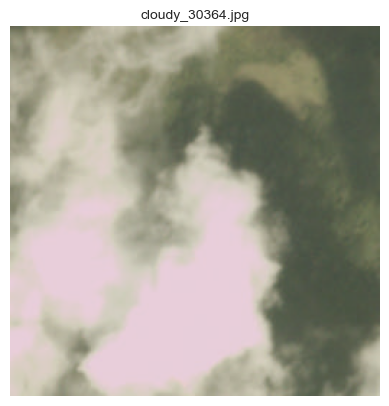

1/1 [==============================] - 0s 31ms/step
The model classifies this as: cloudy with 100.00% confidence 

Example No 2: 



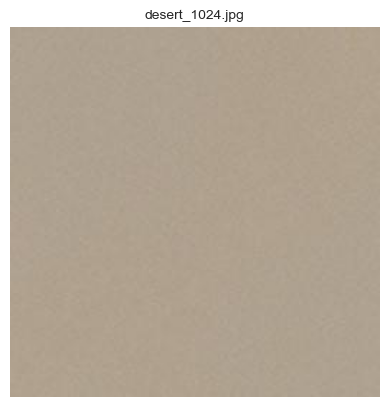

1/1 [==============================] - 0s 33ms/step
The model classifies this as: desert with 100.00% confidence 

Example No 3: 



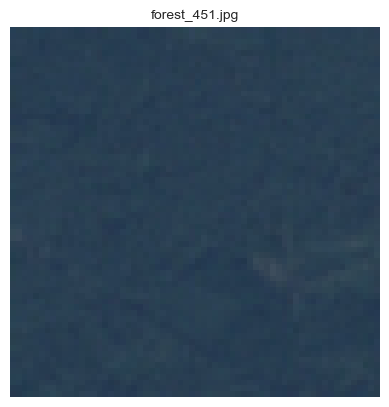

1/1 [==============================] - 0s 32ms/step
The model classifies this as: green_area with 100.00% confidence 



In [57]:
for i in range(1, 4):
    print(f"Example No {i}:", "\n")
    rand_img_dir = np.random.choice(os.listdir(balanced_test_dir + "/" + "test"))
    img_path = os.path.join(balanced_test_dir+ "/" + "test", rand_img_dir)

    img = Image.open(img_path)
    plt.imshow(img)
    plt.axis('off') 
    plt.title(f"{rand_img_dir}", fontsize = 10)
    plt.show()

    img = image.load_img(img_path, target_size=(256, 256))
    img_array = np.expand_dims(image.img_to_array(img), axis=0)

    predictions = model.predict(img_array)
    class_idx = np.argmax(predictions[0])
    class_prob = predictions[0][class_idx]

    class_label = {v: k for k, v in train_bal_ds.class_indices.items()}[class_idx]
    print(f"The model classifies this as: {class_label} with {class_prob*100:.2f}% confidence", "\n")

Unsurprisingly, no mistakes were made.

## <a id = 8.4></a><font color="lightseagreen">8.4 Further Model Optimization<font>

In [51]:
# Function to augment image subsets, set up, compile and run model
# Epochs were set to a standard 35
def run_keras(train_dir, val_dir, callbacks_in_dir, batch_size=32, learning_rate=0.001, epochs=35):  # callbacks_in_dir should be a path in the format "data/epochs/save_at_{epoch}.keras"

    # starting fresh
    keras.backend.clear_session()
    
    print("\n")  # visually separate each session
    
    # loading data
    train_ds = datagen.flow_from_directory(
            train_dir_bal,
            seed=400,
            target_size=image_size,
            batch_size=batch_size,
            class_mode="categorical"
    )
    val_ds = datagen.flow_from_directory(
            val_dir_bal,
            seed=400,
            target_size=image_size,
            batch_size=batch_size,
            class_mode="categorical"
    )
    
    # setting up model
    model = make_model(input_shape=image_size + (3,))
        
    # compiling
    model.compile(
            optimizer=keras.optimizers.Adamax(learning_rate=learning_rate),
            loss="categorical_crossentropy",
            metrics=["accuracy"]
    )
        
    # Where should the callbacks (aka saved instances of the model per epoch) be saved 
    callbacks = [keras.callbacks.ModelCheckpoint(callbacks_in_dir)]
        
    # defining step sizes that will allow the model to run through all data points over each epoch
    step_size_train = train_ds.n//train_ds.batch_size
    
    if batch_size >= train_ds.n:
        step_size_val = train_ds.n
    else:
        step_size_val = val_ds.n//val_ds.batch_size
        
    # creating points of reference to keep track of sections in cell output
    print(" ", f"Epochs/scores for batch_size = {batch_size} and learning_rate = {learning_rate}")
        
    # running model
    hist = model.fit_generator(
            train_ds, 
            epochs=epochs,
            steps_per_epoch = step_size_train,
            validation_data=val_ds,
            validation_steps = step_size_val,
            callbacks = callbacks
    )
    
    print(" ", f"Finished for batch_size = {batch_size}")
            
    # saving scores history in .csv for easy access and visualisations potentially in later sessions
    balanced_hist_df = pd.DataFrame(hist.history)
    balanced_hist_df.to_csv(f"batch{batch_size}_lr{learning_rate}.csv", index = 0)
    
    # to let the pc cool down a bit between each cycle in case the function is called in a loop
    time.sleep(120) 

### <font color="lightseagreen">- Batch Size Optimization<font>

In [55]:
batch_sizes = [32, 64, 256, 300, 450]  # attempts to train the model on one batch failed as the kernal kept dying
callback_paths = []
epoch = "{epoch}"

for batch_size in batch_sizes:
    callback_paths.append(f"data_balance/epochs_bal_batch_{batch_size}/save_at_{epoch}.keras")
    
i = 0

for batch_size in batch_sizes:
    run_keras(train_dir_bal, val_dir_bal, callback_paths[i], batch_size=batch_size, epochs = 20)
    i += 1



Found 3496 images belonging to 4 classes.
Found 436 images belonging to 4 classes.
  Epochs/scores for batch_size = 32
Epoch 1/20
109/109 [==============================] - 165s 2s/step - loss: 0.6567 - accuracy: 0.6801 - val_loss: 0.3979 - val_accuracy: 0.8654
Epoch 2/20
109/109 [==============================] - 163s 1s/step - loss: 0.3944 - accuracy: 0.8421 - val_loss: 0.3412 - val_accuracy: 0.8678
Epoch 3/20
109/109 [==============================] - 163s 1s/step - loss: 0.3891 - accuracy: 0.8389 - val_loss: 0.4294 - val_accuracy: 0.8077
Epoch 4/20
109/109 [==============================] - 161s 1s/step - loss: 0.3701 - accuracy: 0.8470 - val_loss: 0.4311 - val_accuracy: 0.8221
Epoch 5/20
109/109 [==============================] - 173s 2s/step - loss: 0.3800 - accuracy: 0.8484 - val_loss: 0.3449 - val_accuracy: 0.8654
Epoch 6/20
109/109 [==============================] - 173s 2s/step - loss: 0.3772 - accuracy: 0.8418 - val_loss: 0.4341 - val_accuracy: 0.7909
Epoch 7/20
109/109 [=

### <font color="lightseagreen">- Learning Rate Optimization<font>

In [ ]:
lrs = [0.001, 0.003, 0.005, 0.01, 0.05]
callback_paths = []
epoch = "{epoch}"

for learning_rate in lrs:
    callback_paths.append(f"data_balance/epochs_lr_{learning_rate}/save_at_{epoch}.keras")
    
i = 0

for learning_rate in lrs:
    run_keras(train_dir_bal, val_dir_bal, callback_paths[i], batch_size=64, learning_rate = learning_rate, epochs = 30)
    i += 1



Found 3496 images belonging to 4 classes.
Found 436 images belonging to 4 classes.
  Epochs/scores for batch_size = 64 and learning_rate = 0.001
Epoch 1/30
54/54 [==============================] - 163s 3s/step - loss: 0.6614 - accuracy: 0.6970 - val_loss: 0.3472 - val_accuracy: 0.8646
Epoch 2/30
54/54 [==============================] - 163s 3s/step - loss: 0.3651 - accuracy: 0.8464 - val_loss: 0.3870 - val_accuracy: 0.8307
Epoch 3/30
54/54 [==============================] - 168s 3s/step - loss: 0.3503 - accuracy: 0.8514 - val_loss: 0.3098 - val_accuracy: 0.9036
Epoch 4/30
54/54 [==============================] - 166s 3s/step - loss: 0.3356 - accuracy: 0.8631 - val_loss: 0.3245 - val_accuracy: 0.8724
Epoch 5/30
54/54 [==============================] - 159s 3s/step - loss: 0.3415 - accuracy: 0.8575 - val_loss: 0.3682 - val_accuracy: 0.8672
Epoch 6/30
54/54 [==============================] - 169s 3s/step - loss: 0.3241 - accuracy: 0.8689 - val_loss: 0.3145 - val_accuracy: 0.8880
Epoch 7

As can be observred by the results above, the model performed better and reached higher levels of accuracy faster when trained with batches of 64 images and the more conservative learning rate of 0.001 from the values it has been tested on. The progress of the model with this configuration by the 30th epoch was almost identical to that of the model running with a batch size of 128 and the same learning rate. It remains to be tested  while running up to 50 epochs to reach a final decision.